# Trabajo Práctico 1 : Reservas de Hotel

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

- RUIZ, Karen Belén

## Checkpoint 2

El preprocesamiento que se le hace a los datos de test siempre es:

- TBD

Preparación de librerías

In [1]:
%pip install dtreeviz==2.2.2
%pip install joblib
%pip install pydotplus
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

from sklearn.linear_model import BayesianRidge
from pandas.plotting import scatter_matrix
from sklearn.preprocessing  import  LabelEncoder
from scipy.spatial.distance import mahalanobis

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

import pydotplus
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import os
print(os.environ['PATH'])

/bin:/home/ale/.local/bin:/home/ale/.cargo/bin:/home/ale/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin:/home/ale/.local/bin:/home/ale/.cargo/bin:/home/ale/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin


### Modelo 1

Este modelo será usando el CSV resultado del preprocesado del Checkpoint 1 y sin optimización de hiperparámetros

In [4]:
hotels = pd.read_csv("./new_hotel_train.csv")
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43392 entries, 0 to 43391
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           43392 non-null  object 
 1   lead_time                       43392 non-null  int64  
 2   arrival_date_year               43392 non-null  int64  
 3   arrival_date_month              43392 non-null  object 
 4   arrival_date_week_number        43392 non-null  int64  
 5   arrival_date_day_of_month       43392 non-null  int64  
 6   stays_in_weekend_nights         43392 non-null  int64  
 7   stays_in_week_nights            43392 non-null  int64  
 8   adults                          43392 non-null  int64  
 9   children                        43392 non-null  float64
 10  babies                          43392 non-null  int64  
 11  meal                            43392 non-null  object 
 12  country                         

Es necesario hacer encoding a las variables categóricas para que el árbol de decisión pueda ser entrenado. Utilizamos one-hot encoding para generar variables dummies

Eliminamos la columna de id, ya que sino generaría 1 variable dummy por entrada y no aporta información. Sin embargo,  no eliminamos valores para saber que estos siguen siendo las mismas entradas

In [5]:
hotelsTree = hotels.copy().drop(["id"], axis="columns")

In [6]:
categorics = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "customer_type", "deposit_type"]

hotelsTree = pd.get_dummies(hotelsTree, columns=categorics, drop_first=True)
hotelsTree = hotelsTree.sort_index(axis=1, ascending=False)
hotelsTree.head(3)

total_of_special_requests  stays_in_weekend_nights  stays_in_week_nights  \
0                          1                        1                     2   
1                          0                        0                     1   
2                          0                        2                     5   

   reserved_room_type_P  reserved_room_type_H  reserved_room_type_G  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                 False   

   reserved_room_type_F  reserved_room_type_E  reserved_room_type_D  \
0                 False                 False                  True   
1                 False                 False                 False   
2                 False                 False                 False   

   reserved_room_type_C  ...  arrival_date_month_June  \
0                 False  ...                    False   
1                 False  ...                    False   
2                 False  ...                    False   

   arrival_date_month_July  arrival_date_month_January  \
0                    False                       False   
1                    False                       False   
2                    False                       False   

   arrival_date_month_February  arrival_date_month_December  \
0                        False                        False   
1                        False                        False   
2                        False                         True   

   arrival_date_month_August  arrival_date_day_of_month       agent  adults  \
0                      False                          5    9.000000       1   
1                      False                         31  242.547438       2   
2                      False                         12  154.000000       2   

     adr  
0  115.5  
1   42.0  
2   75.0  

[3 rows x 210 columns]

In [7]:
hotelsTree.shape

(43392, 210)

Nos quedamos con el dataset sin el target y el target por separado para hacer el split. Elegimos una proporción 70-30 

In [8]:
hotels_x = hotelsTree.drop(['is_canceled'], axis='columns', inplace=False)
hotels_y = hotelsTree['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(hotels_x,
                                                    hotels_y,
                                                    test_size=0.3,
                                                    random_state=0)

Inspeccionamos los resultados

In [9]:
x_train.head(2)

total_of_special_requests  stays_in_weekend_nights  \
21465                          0                        1   
15306                          1                        2   

       stays_in_week_nights  reserved_room_type_P  reserved_room_type_H  \
21465                     2                 False                 False   
15306                     3                 False                 False   

       reserved_room_type_G  reserved_room_type_F  reserved_room_type_E  \
21465                 False                 False                 False   
15306                 False                 False                 False   

       reserved_room_type_D  reserved_room_type_C  ...  \
21465                 False                 False  ...   
15306                 False                 False  ...   

       arrival_date_month_June  arrival_date_month_July  \
21465                    False                    False   
15306                    False                    False   

       arrival_date_month_January  arrival_date_month_February  \
21465                       False                        False   
15306                       False                        False   

       arrival_date_month_December  arrival_date_month_August  \
21465                        False                      False   
15306                        False                       True   

       arrival_date_day_of_month      agent  adults    adr  
21465                         15  61.289945       2  170.0  
15306                          7  14.000000       1   75.0  

[2 rows x 209 columns]

In [10]:
x_test.head(2)

total_of_special_requests  stays_in_weekend_nights  \
13394                          0                        0   
38024                          0                        0   

       stays_in_week_nights  reserved_room_type_P  reserved_room_type_H  \
13394                     4                 False                 False   
38024                     1                 False                 False   

       reserved_room_type_G  reserved_room_type_F  reserved_room_type_E  \
13394                 False                 False                 False   
38024                 False                 False                 False   

       reserved_room_type_D  reserved_room_type_C  ...  \
13394                 False                 False  ...   
38024                 False                 False  ...   

       arrival_date_month_June  arrival_date_month_July  \
13394                    False                    False   
38024                    False                    False   

       arrival_date_month_January  arrival_date_month_February  \
13394                       False                         True   
38024                        True                        False   

       arrival_date_month_December  arrival_date_month_August  \
13394                        False                      False   
38024                        False                      False   

       arrival_date_day_of_month      agent  adults   adr  
13394                         15  44.750143       2  78.0  
38024                         18  19.000000       1  75.0  

[2 rows x 209 columns]

In [11]:
y_train.head(2)

21465    1
15306    0
Name: is_canceled, dtype: int64

In [12]:
y_test.head(2)

13394    0
38024    0
Name: is_canceled, dtype: int64

Elegimos una configuración inicial arbitraria de hiperparámetros y entrenamos el árbol de decisión con los datos

In [13]:
decisionTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 20, min_samples_leaf=10)

decisionTreeTrained = decisionTree.fit(X = x_train, y = y_train)

Realizamos la predicción de los datos de test

In [14]:
y_pred = decisionTreeTrained.predict(x_test)

Calculamos diversas métricas de los resultados

In [15]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8246274389307113
Recall: 0.8426914153132251
Precision: 0.8114387846291331
f1 score: 0.8267698611427271


Hacemos una matriz de confusión para observar estas métricas

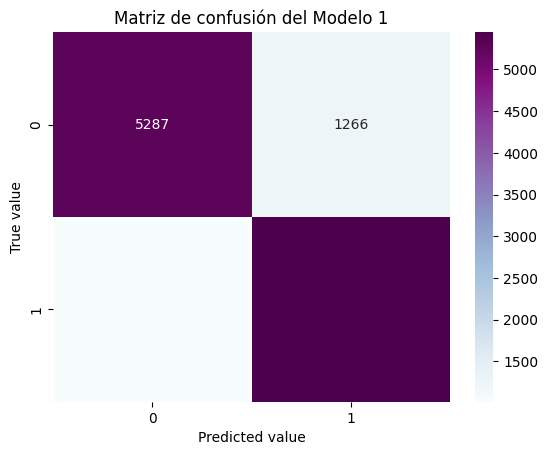

In [16]:
confussionMatrix = confusion_matrix(y_true=y_test,y_pred=y_pred)

sns.heatmap(confussionMatrix, cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo 1")
plt.show()

Ahora realizamos las predicciones del dataset de test que serán subidas a Kaggle

In [17]:
hotelsTest = pd.read_csv("./hotels_test.csv")
hotelsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

In [18]:
hotelsTest.shape

(26535, 30)

Hacemos un análisis de valores nulos

In [19]:
hotelsTest.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


Hacemos el mismo tratamiento de datos faltantes que hicimos en el checkpoint 1:

Eliminamos la columna company

In [20]:
hotelsTestFiltered = hotelsTest.copy().drop(columns=["company"])

Los nulos que quedan son

In [21]:
nullsFiltered = hotelsTestFiltered.get(["agent", "country"]).isnull()

nullsStats = pd.DataFrame({"Cantidad de Nulos": nullsFiltered.sum(), "Porcentaje de nulos": round(nullsFiltered.mean() * 100, 2)})
nullsStats

Cantidad de Nulos  Porcentaje de nulos
agent                 3363                12.67
country                 95                 0.36

Hacemos label encoding para luego imputar estos datos nulos

In [22]:
varsToEncode = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel","reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "id"]
labelEncoders = {}

for varToEncode in varsToEncode:
    encoder = LabelEncoder()
    hotelsTestFiltered[varToEncode] = encoder.fit_transform(hotelsTestFiltered[varToEncode])
    labelEncoders[varToEncode] = encoder

In [23]:
imputer = IterativeImputer(estimator=BayesianRidge(), missing_values=np.nan, max_iter=10, verbose=0, random_state=0)

originalDtypes = hotelsTestFiltered.dtypes
imputedAndFilteredTest = hotelsTestFiltered.copy()

imputedAndFilteredTest = pd.DataFrame(imputer.fit_transform(imputedAndFilteredTest), columns=imputedAndFilteredTest.columns)

In [24]:
imputedAndFilteredTest["agent"] = imputedAndFilteredTest["agent"].clip(lower=hotelsTestFiltered.agent.min(), upper=hotelsTestFiltered.agent.max())
imputedAndFilteredTest["country"] = imputedAndFilteredTest["country"].clip(lower=hotelsTestFiltered.country.min(), upper=hotelsTestFiltered.country.max())
imputedAndFilteredTest = imputedAndFilteredTest.astype(originalDtypes)

Decodeamos

In [25]:
for varToEncode in varsToEncode:
    encoder = labelEncoders.get(varToEncode)
    imputedAndFilteredTest[varToEncode] = encoder.inverse_transform(imputedAndFilteredTest[varToEncode])

In [26]:
imputedAndFilteredTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

Ahora, igual que a los datos de train más arriba, hacemos one-hot encoding a los datos de test

Guardamos las ids para posterior math entre resultado y id

In [27]:
hotelsTestIds = imputedAndFilteredTest["id"]

In [28]:
imputedAndFilteredTestEncoded = imputedAndFilteredTest.copy()
imputedAndFilteredTestEncoded.drop(["id"], axis="columns", inplace=True)
imputedAndFilteredTestEncoded = pd.get_dummies(imputedAndFilteredTestEncoded, columns=categorics, drop_first=True)

imputedAndFilteredTestEncoded.head(3)

lead_time  arrival_date_year  arrival_date_week_number  \
0        277               2016                        46   
1        286               2016                        20   
2          0               2016                        35   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                          7                        1                     2   
1                         11                        0                     4   
2                         23                        0                     1   

   adults  children  babies  is_repeated_guest  ...  assigned_room_type_G  \
0       2       0.0       0                  0  ...                 False   
1       2       0.0       0                  0  ...                 False   
2       3       0.0       0                  0  ...                 False   

   assigned_room_type_H  assigned_room_type_I  assigned_room_type_K  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                 False   

   assigned_room_type_P  customer_type_Group  customer_type_Transient  \
0                 False                False                     True   
1                 False                False                    False   
2                 False                False                     True   

   customer_type_Transient-Party  deposit_type_Non Refund  \
0                          False                     True   
1                           True                    False   
2                          False                    False   

   deposit_type_Refundable  
0                    False  
1                    False  
2                    False  

[3 rows x 201 columns]

In [29]:
imputedAndFilteredTestEncoded.shape

(26535, 201)

Comparamos el shape con el dataset de train, ya que el árbol "entenderá" la estructura con la que fue entrenado

In [30]:
hotelsTree.shape

(43392, 210)

Observamos que hay una discrepancia, así que obtenemos las columnas que están presentes de manera única en cada dataset

In [31]:
hotelsTreeWithoutTarget = hotelsTree.copy()
hotelsTreeWithoutTarget.drop(["is_canceled"], axis="columns", inplace=True)
hotelsTreeColumns = set(hotelsTreeWithoutTarget.columns)
imputedAndFilteredTestEncodedColumns = set(imputedAndFilteredTestEncoded.columns)

columnsOnlyInHotelsTree = np.array(list(hotelsTreeColumns - imputedAndFilteredTestEncodedColumns)).tolist()

columnsOnlyInImputedAndFiltered = np.array(list(imputedAndFilteredTestEncodedColumns - hotelsTreeColumns)).tolist()

print("Columnas presentes solamente en hotelsTree:", columnsOnlyInHotelsTree)
print("Columnas presentes solamente en imputedAndFilteredTestEncoded:", columnsOnlyInImputedAndFiltered)

Columnas presentes solamente en hotelsTree: ['country_FJI', 'country_FRO', 'country_ETH', 'country_PAN', 'country_BEN', 'country_MUS', 'country_TGO', 'country_SDN', 'country_CIV', 'country_SYC', 'country_MNE', 'country_KEN', 'country_SYR', 'country_NAM', 'country_AZE', 'country_MDG', 'country_UMI', 'country_MYT', 'country_ZMB', 'country_VGB', 'country_ARM', 'country_HND', 'country_COM']
Columnas presentes solamente en imputedAndFilteredTestEncoded: ['country_UZB', 'country_SMR', 'country_ASM', 'country_SLV', 'country_ATF', 'country_STP', 'country_NIC', 'country_DMA', 'country_GHA', 'reserved_room_type_L', 'country_KHM', 'country_DJI', 'country_MLI', 'country_BFA', 'country_TMP']


Eliminamos las columnas presentes sólo en los datos de test que no fueron vistos durante el entrenamiento

In [32]:
imputedAndFilteredTestEncoded.drop(columnsOnlyInImputedAndFiltered, axis="columns", inplace=True)
imputedAndFilteredTestEncoded.shape

(26535, 186)

Agregamos las columnas faltantes a los datos de test que sí están en los datos de train, ponemos sus valores en 0

In [33]:
for column in columnsOnlyInHotelsTree:
    imputedAndFilteredTestEncoded[column] = 0

imputedAndFilteredTestEncoded = imputedAndFilteredTestEncoded.sort_index(axis=1, ascending=False)
imputedAndFilteredTestEncoded.shape

(26535, 209)

In [34]:
hotelsTreeWithoutTarget.shape

(43392, 209)

Realizamos la predicción de los valores de test:

In [35]:
y_pred = decisionTreeTrained.predict(imputedAndFilteredTestEncoded)
len(y_pred)

26535

Agrupamos en el dataframe el id que guardamos antes y los valores predichos

In [36]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(10)

total_of_special_requests  stays_in_weekend_nights  stays_in_week_nights  \
0                          0                        1                     2   
1                          0                        0                     4   
2                          2                        0                     1   
3                          0                        2                     5   
4                          0                        2                     1   
5                          0                        0                     2   
6                          0                        0                     1   
7                          1                        2                     3   
8                          1                        0                     4   
9                          0                        1                     1   

   reserved_room_type_P  reserved_room_type_H  reserved_room_type_G  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                 False   
3                 False                 False                  True   
4                 False                 False                 False   
5                 False                 False                 False   
6                 False                 False                 False   
7                 False                 False                 False   
8                 False                 False                 False   
9                 False                 False                 False   

   reserved_room_type_F  reserved_room_type_E  reserved_room_type_D  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                  True   
3                 False                 False                 False   
4                 False                 False                 False   
5                 False                 False                 False   
6                  True                 False                 False   
7                 False                 False                 False   
8                 False                 False                  True   
9                 False                 False                  True   

   reserved_room_type_C  ...  arrival_date_month_January  \
0                 False  ...                       False   
1                 False  ...                       False   
2                 False  ...                       False   
3                 False  ...                       False   
4                 False  ...                       False   
5                 False  ...                       False   
6                 False  ...                       False   
7                 False  ...                       False   
8                 False  ...                       False   
9                 False  ...                       False   

   arrival_date_month_February  arrival_date_month_December  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   
5                        False                        False   
6                        False                        False   
7                        False                        False   
8                        False                        False   
9                        False                        False   

   arrival_date_month_August  arrival_date_day_of_month       agent  adults  \
0                      False                          7   36.162958       2   
1                      False                         11 

Para exportar a Kaggle hacemos lo siguiente

In [37]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [38]:
exportResult.head(2)

id  is_canceled
0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1
1  aba9aac2-4495-4645-a60e-90328713c999            1

In [39]:
exportResult.to_csv("submit_01_grupo16_gpwin.csv", index=False)

Luego de obtener las predicciones del dataset para submitear en Kaggle, obtuvimos un score en Kaggle de: 0.58393

### Modelo 2

Este modelo será usando el CSV resultado del preprocesado del Checkpoint 1 y con optimización de hiperparámetros

Tomando el mismo dataset de training usado en el modelo 1, es decir, el que salió del checkpoint 1 y le aplicamos one-hot encoding, realizamos una optimización de hiperparámetros con k-fold cross validation, donde la cantidad de folds es 5 (i.e. 80-20 train-test), y la métrica que se optimizará de manera aleatoria (random search) será el score f1. Todo esto partiendo de un split train-test con relación 70/30.

In [40]:
hotels_x_m2 = hotelsTreeWithoutTarget
hotels_y_m2 = hotelsTree["is_canceled"]

x_train_m2, x_test_m2, y_train_m2, y_test_m2 = train_test_split(hotels_x_m2,
                                                    hotels_y_m2,
                                                    test_size=0.3,
                                                    random_state=0)

In [41]:
n=1000

parametersGrid = {
                    'criterion': ['gini', 'entropy'],
                    'max_depth': list(range(1, 200)),
                    'ccp_alpha': np.linspace(0, 0.01, n),
                    'min_samples_split': list(range(2, 20)),
                    'min_samples_leaf': list(range(1, 10)),
                    'max_features': ['auto', 'sqrt', 'log2', None],
               }

folds = 5
kFoldCV = StratifiedKFold(n_splits = folds)
starterTree = DecisionTreeClassifier()
scorerF1 = make_scorer(f1_score)

randomSearchCV = RandomizedSearchCV(estimator = starterTree,
                                    param_distributions = parametersGrid,
                                    scoring = scorerF1,
                                    cv = kFoldCV,
                                    n_iter = n,
                                    n_jobs = -1,
                                    random_state = 0)

randomSearchCV.fit(x_train_m2,y_train_m2)

/home/ale/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1190 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
728 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/ale/.local/lib/pytho

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.00100100e-05, 2.00200200e-05, 3.00300300e-05,
       4.00400400e-05, 5.00500501e-05, 6.00600601e-05, 7.00700701e-05,
       8.00800801e-05, 9.00900901e-05, 1.00100100e-04, 1.1011...
       9.96996997e-03, 9.97997998e-03, 9.98998999e-03, 1.00000000e-02]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=0, scoring=make_scorer(f1_score))

In [42]:
hotelsTreeWithoutTarget.shape

(43392, 209)

Obtenemos del random search el árbol con los hiperparámetros que obtuvo mejor score

In [43]:
bestTree = randomSearchCV.best_estimator_

Lo fiteamos al conjunto de datos total de train

In [44]:
bestTree.fit(x_train_m2,y_train_m2)

DecisionTreeClassifier(ccp_alpha=0.0002002002002002002, max_depth=170,
                       min_samples_leaf=3, min_samples_split=15)

Realizamos las predicciones con el split de test que se hizo

In [45]:
y_pred_m2 = bestTree.predict(x_test_m2)

Imprimimos la matriz de confusión

F1-Score: 0.8382606092358357


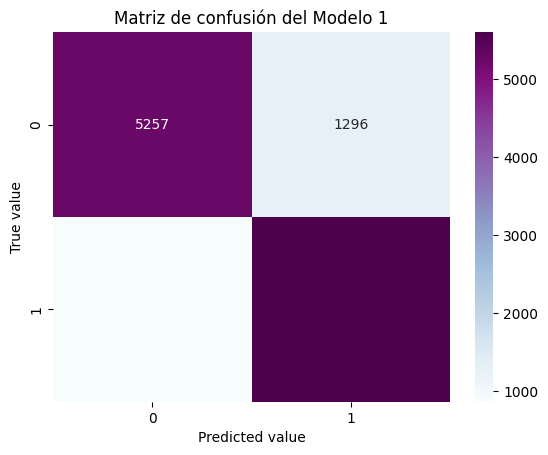

In [46]:
print('F1-Score: {}'.format(f1_score(y_test_m2, y_pred_m2, average='binary')))

confussionMatrix = confusion_matrix(y_test_m2,y_pred_m2)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo 1")
plt.show()

Mostramos las distintas métricas

In [47]:
accuracy = accuracy_score(y_test_m2, y_pred_m2)
recall = recall_score(y_test_m2, y_pred_m2)
f1 = f1_score(y_test_m2, y_pred_m2)
precision = precision_score(y_test_m2, y_pred_m2)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8339990781994162
Recall: 0.8662026295436969
Precision: 0.8120649651972158
f1 score: 0.8382606092358357


Realizamos las predicciones con este mejor árbol

In [48]:
testFilteredWithoutTargetNorId = imputedAndFilteredTestEncoded.copy().drop(["id", "is_canceled"], axis="columns", inplace=False)
y_pred = bestTree.predict(testFilteredWithoutTargetNorId)

Obtenemos el score interno que sacó el mejor conjunto de hiperparámetros y el índice de splitting

In [49]:
bestScore = randomSearchCV.best_score_
indexOfBestFoldSplit = randomSearchCV.best_index_

print("Best F1 Score:", bestScore)
print("Fold Split Index for Best Model:", indexOfBestFoldSplit)

Best F1 Score: 0.8414785782684229
Fold Split Index for Best Model: 798


Agrupamos en el dataframe el id que guardamos antes y los valores predichos

In [50]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(5)

total_of_special_requests  stays_in_weekend_nights  stays_in_week_nights  \
0                          0                        1                     2   
1                          0                        0                     4   
2                          2                        0                     1   
3                          0                        2                     5   
4                          0                        2                     1   

   reserved_room_type_P  reserved_room_type_H  reserved_room_type_G  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                 False   
3                 False                 False                  True   
4                 False                 False                 False   

   reserved_room_type_F  reserved_room_type_E  reserved_room_type_D  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                  True   
3                 False                 False                 False   
4                 False                 False                 False   

   reserved_room_type_C  ...  arrival_date_month_January  \
0                 False  ...                       False   
1                 False  ...                       False   
2                 False  ...                       False   
3                 False  ...                       False   
4                 False  ...                       False   

   arrival_date_month_February  arrival_date_month_December  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   

   arrival_date_month_August  arrival_date_day_of_month       agent  adults  \
0                      False                          7   36.162958       2   
1                      False                         11   30.000000       2   
2                       True                         23   15.832362       3   
3                      False                         29  240.000000       2   
4                      False                         26   11.000000       2   

     adr                                    id  is_canceled  
0  100.0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1  
1  101.0  aba9aac2-4495-4645-a60e-90328713c999            1  
2  225.0  b345b5dc-c804-4d77-a39f-1f4e65d1f1ad            0  
3   96.0  ce1b400e-afa1-4946-bdff-004b859eb61c            1  
4   30.0  c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214            1  

[5 rows x 211 columns]

Para exportar a Kaggle hacemos lo siguiente

In [51]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [52]:
exportResult.head(2)

id  is_canceled
0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1
1  aba9aac2-4495-4645-a60e-90328713c999            1

Número de corrida de optimización de hiperparámetros

In [53]:
runNumber = 21

In [54]:
exportResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_m2.csv", index=False)

También nos guardamos una serialización del árbol

In [55]:
filename = f'./best_decision_tree_model_with_hyperparams{runNumber}_m2.joblib'
modelInfo = {'best_estimator': bestTree, 'hyperparameters': bestTree.get_params()}

joblib.dump(modelInfo, filename)

['./best_decision_tree_model_with_hyperparams21_m2.joblib']

Mostramos y guardamos en un archivo de texto los hiperparámetros, junto con el score

In [56]:
hyperparameters = bestTree.get_params()

print("Mejor conjunto de hiperparámetros:")
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Mejor conjunto de hiperparámetros:
ccp_alpha: 0.0002002002002002002
class_weight: None
criterion: gini
max_depth: 170
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 3
min_samples_split: 15
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best


In [57]:
filename = f'./best_estimator_hyperparameters{runNumber}_m2.txt'

with open(filename, 'w') as file:
    file.write("Mejor conjunto de hiperparámetros:\n")
    for param, value in hyperparameters.items():
        file.write(f"{param}: {value}\n")

    file.write(f"\nBest F1 Score: {bestScore}")
    file.write(f"\nFold Split Index for Best Set: {indexOfBestFoldSplit}")

print(f"Mejor conjunto de hiperparámetros guardado en: '{filename}'")

Mejor conjunto de hiperparámetros guardado en: './best_estimator_hyperparameters21_m2.txt'


### Modelo 3

Este modelo será usando el CSV original realizando un preprocesamiento diferente al del TP1, pero partiendo de todo el conocimiento del problema ya adquirido. 

In [58]:
hotelsTrainOriginal = pd.read_csv("./hotels_train.csv")
hotelsTrainOriginal.info()
hotelsTrainOriginal.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61913 entries, 0 to 61912
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           61913 non-null  object 
 1   lead_time                       61913 non-null  int64  
 2   arrival_date_year               61913 non-null  int64  
 3   arrival_date_month              61913 non-null  object 
 4   arrival_date_week_number        61913 non-null  int64  
 5   arrival_date_day_of_month       61913 non-null  int64  
 6   stays_in_weekend_nights         61913 non-null  int64  
 7   stays_in_week_nights            61913 non-null  int64  
 8   adults                          61913 non-null  int64  
 9   children                        61909 non-null  float64
 10  babies                          61913 non-null  int64  
 11  meal                            61913 non-null  object 
 12  country                         

(61913, 31)

Realizamos la limpieza del set de train

Como se aprecia a continuacion vemos que tenemos valores nulos en tres variables. En el preprocesamiento anterior los hemos imputado utilizando la técnica MICE.

Para este tercer modelo decidimos no imputarlos y simplemente retirarlas los registros (observaciones) del dataset. Dado que buscamos analizar si, al realizar la imputacion no estamos modificando profudamente y de forma equivocada el arbol de deisicion que se genera avitando conseguir el mejor predictor.

In [59]:
nullValues = hotelsTrainOriginal.isnull().sum()

Eliminamos las observaciones con valores nulos. ("Company" se elimina directamente como variable dado su gran porcentaje de nulos).

In [60]:
hotelsTree = hotelsTrainOriginal.drop(columns=["company"])
hotelsTree = hotelsTree.dropna()
nullValues = hotelsTree.isnull().sum()
print(nullValues)

hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

Con este dataset sin nulos pero con Outliers provederemos a entrenar nuestro modelo. 

De igual forma que hicimos  para el modelo 1 y 2, procedemos quitando el "id".

In [61]:
hotelsTree = hotelsTree.copy().drop(["id"], axis="columns")

Realizamos el one-hot encoding de las variables categoricas.

In [62]:
categorics = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "customer_type", "deposit_type"]

hotelsTree = pd.get_dummies(hotelsTree, columns= categorics, drop_first=True)
hotelsTree = hotelsTree.sort_index(axis=1, ascending=False)
hotelsTree.head(3)

total_of_special_requests  stays_in_weekend_nights  stays_in_week_nights  \
0                          1                        1                     2   
2                          2                        0                     1   
3                          0                        2                     5   

   reserved_room_type_H  reserved_room_type_G  reserved_room_type_F  \
0                 False                 False                 False   
2                 False                 False                  True   
3                 False                 False                 False   

   reserved_room_type_E  reserved_room_type_D  reserved_room_type_C  \
0                 False                  True                 False   
2                 False                 False                 False   
3                 False                 False                 False   

   reserved_room_type_B  ...  arrival_date_month_June  \
0                 False  ...                    False   
2                 False  ...                    False   
3                 False  ...                    False   

   arrival_date_month_July  arrival_date_month_January  \
0                    False                       False   
2                    False                       False   
3                    False                       False   

   arrival_date_month_February  arrival_date_month_December  \
0                        False                        False   
2                        False                        False   
3                        False                         True   

   arrival_date_month_August  arrival_date_day_of_month  agent  adults    adr  
0                      False                          5    9.0       1  115.5  
2                      False                         13    9.0       2  229.0  
3                      False                         12  154.0       2   75.0  

[3 rows x 211 columns]

In [63]:
hotelsTree.shape

(53944, 211)

Verificamos columnas distintas

In [64]:
hotelsTreeWithoutTarget = hotelsTree.copy()
hotelsTreeWithoutTarget.drop(["is_canceled"], axis="columns", inplace=True)
hotelsTreeColumns = set(hotelsTreeWithoutTarget.columns)
imputedAndFilteredTestEncodedColumns = set(imputedAndFilteredTestEncoded.columns)

columnsOnlyInHotelsTree = np.array(list(hotelsTreeColumns - imputedAndFilteredTestEncodedColumns)).tolist()

columnsOnlyInImputedAndFiltered = np.array(list(imputedAndFilteredTestEncodedColumns - hotelsTreeColumns)).tolist()

print("Columnas presentes solamente en hotelsTree:", columnsOnlyInHotelsTree)
print("Columnas presentes solamente en imputedAndFilteredTestEncoded:", columnsOnlyInImputedAndFiltered)

Columnas presentes solamente en hotelsTree: ['country_GHA', 'country_PYF', 'country_KNA', 'country_GTM']
Columnas presentes solamente en imputedAndFilteredTestEncoded: ['is_canceled', 'country_MDG', 'assigned_room_type_P', 'reserved_room_type_P', 'id']


In [65]:
imputedAndFilteredTestEncoded.drop(columnsOnlyInImputedAndFiltered, axis="columns", inplace=True)
imputedAndFilteredTestEncoded.shape

(26535, 206)

In [66]:
for column in columnsOnlyInHotelsTree:
    imputedAndFilteredTestEncoded[column] = 0

imputedAndFilteredTestEncoded = imputedAndFilteredTestEncoded.sort_index(axis=1, ascending=False)
imputedAndFilteredTestEncoded.shape

(26535, 210)

Seguimos el mismo proceso que hicimos con el modelo 2, mismos folds y split Train-Test

In [67]:
hotels_x_m3 = hotelsTreeWithoutTarget
hotels_y_m3 = hotelsTree["is_canceled"]

x_train_m3, x_test_m3, y_train_m3, y_test_m3 = train_test_split(hotels_x_m3,
                                                    hotels_y_m3,
                                                    test_size=0.3,
                                                    random_state=0)

In [68]:
n=1000

parametersGrid = {
                    'criterion': ['gini', 'entropy'],
                    'max_depth': list(range(1, 200)),
                    'ccp_alpha': np.linspace(0, 0.01, n),
                    'min_samples_split': list(range(2, 20)),
                    'min_samples_leaf': list(range(1, 10)),
                    'max_features': ['auto', 'sqrt', 'log2', None],
               }

folds = 5
kFoldCV = StratifiedKFold(n_splits = folds)
starterTree = DecisionTreeClassifier()
scorerF1 = make_scorer(f1_score)

randomSearchCV = RandomizedSearchCV(estimator = starterTree,
                                    param_distributions = parametersGrid,
                                    scoring = scorerF1,
                                    cv = kFoldCV,
                                    n_iter = n,
                                    n_jobs = -1,
                                    random_state = 0)

randomSearchCV.fit(x_train_m3,y_train_m3)

/home/ale/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1190 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
742 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/ale/.local/lib/pytho

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.00100100e-05, 2.00200200e-05, 3.00300300e-05,
       4.00400400e-05, 5.00500501e-05, 6.00600601e-05, 7.00700701e-05,
       8.00800801e-05, 9.00900901e-05, 1.00100100e-04, 1.1011...
       9.96996997e-03, 9.97997998e-03, 9.98998999e-03, 1.00000000e-02]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=0, scoring=make_scorer(f1_score))

In [69]:
hotelsTreeWithoutTarget.shape

(53944, 210)

In [70]:
bestTree = randomSearchCV.best_estimator_

Igual que antes, ahora lo fiteamos a toda la data de train que nos dejamos

In [71]:
bestTree.fit(x_train_m3,y_train_m3)

DecisionTreeClassifier(ccp_alpha=0.0002102102102102102, criterion='entropy',
                       max_depth=45, min_samples_leaf=9, min_samples_split=17)

In [72]:
y_pred_m3 = bestTree.predict(x_test_m3)

Mostramos la matriz de confusión y luego las métricas

F1-Score: 0.8592167652051748


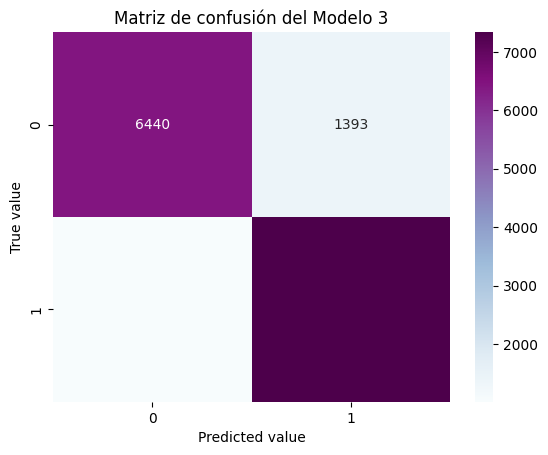

In [84]:
print('F1-Score: {}'.format(f1_score(y_test_m3, y_pred_m3, average='binary')))

confussionMatrix = confusion_matrix(y_test_m3,y_pred_m3)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo 3")
plt.show()

In [74]:
accuracy = accuracy_score(y_test_m2, y_pred_m2)
recall = recall_score(y_test_m2, y_pred_m2)
f1 = f1_score(y_test_m2, y_pred_m2)
precision = precision_score(y_test_m2, y_pred_m2)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8339990781994162
Recall: 0.8662026295436969
Precision: 0.8120649651972158
f1 score: 0.8382606092358357


Realizamos las predicciones para subirlas a kaggle

In [75]:
y_pred = bestTree.predict(imputedAndFilteredTestEncoded)

In [76]:
bestScore = randomSearchCV.best_score_
indexOfBestFoldSplit = randomSearchCV.best_index_

print("Best F1 Score:", bestScore)
print("Fold Split Index for Best Model:", indexOfBestFoldSplit)

Best F1 Score: 0.8540135696265759
Fold Split Index for Best Model: 220


In [77]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(5)

total_of_special_requests  stays_in_weekend_nights  stays_in_week_nights  \
0                          0                        1                     2   
1                          0                        0                     4   
2                          2                        0                     1   
3                          0                        2                     5   
4                          0                        2                     1   

   reserved_room_type_H  reserved_room_type_G  reserved_room_type_F  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                 False                 False   
3                 False                  True                 False   
4                 False                 False                 False   

   reserved_room_type_E  reserved_room_type_D  reserved_room_type_C  \
0                 False                 False                 False   
1                 False                 False                 False   
2                 False                  True                 False   
3                 False                 False                 False   
4                 False                 False                 False   

   reserved_room_type_B  ...  arrival_date_month_January  \
0                 False  ...                       False   
1                 False  ...                       False   
2                 False  ...                       False   
3                 False  ...                       False   
4                 False  ...                       False   

   arrival_date_month_February  arrival_date_month_December  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   

   arrival_date_month_August  arrival_date_day_of_month       agent  adults  \
0                      False                          7   36.162958       2   
1                      False                         11   30.000000       2   
2                       True                         23   15.832362       3   
3                      False                         29  240.000000       2   
4                      False                         26   11.000000       2   

     adr                                    id  is_canceled  
0  100.0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1  
1  101.0  aba9aac2-4495-4645-a60e-90328713c999            1  
2  225.0  b345b5dc-c804-4d77-a39f-1f4e65d1f1ad            0  
3   96.0  ce1b400e-afa1-4946-bdff-004b859eb61c            1  
4   30.0  c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214            1  

[5 rows x 212 columns]

In [78]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [79]:
exportResult.to_csv(f"submit_{runNumber}_grupo16_mod3_gpwin.csv", index=False)

In [80]:
filename = f'./best_decision_tree_model_with_hyperparams{runNumber}_m3.joblib'
modelInfo = {'best_estimator': bestTree, 'hyperparameters': bestTree.get_params()}

joblib.dump(modelInfo, filename)

['./best_decision_tree_model_with_hyperparams21_m3.joblib']

In [81]:
hyperparameters = bestTree.get_params()

print("Mejor conjunto de hiperparámetros:")
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Mejor conjunto de hiperparámetros:
ccp_alpha: 0.0002102102102102102
class_weight: None
criterion: entropy
max_depth: 45
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 9
min_samples_split: 17
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best


In [82]:
filename = f'./best_estimator_hyperparameters{runNumber}_m3.txt'

with open(filename, 'w') as file:
    file.write("Mejor conjunto de hiperparámetros:\n")
    for param, value in hyperparameters.items():
        file.write(f"{param}: {value}\n")

    file.write(f"\nBest F1 Score: {bestScore}")
    file.write(f"\nFold Split Index for Best Set: {indexOfBestFoldSplit}")

print(f"Mejor conjunto de hiperparámetros guardado en: '{filename}'")

Mejor conjunto de hiperparámetros guardado en: './best_estimator_hyperparameters21_m3.txt'


Imprimimos el árbol entero, este árbol lo tomamos como el mejor predictor de los que obtuvimos

In [83]:
feature_names = hotelsTreeWithoutTarget.columns.to_list()

dot_data = StringIO()
export_graphviz(bestTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=feature_names,
                class_names=['good','bad'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())